### Creating Transformer Using IMDB dataset

In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
## Load ataset 

(train_data, train_label), (test_data, test_label) = tf.keras.datasets.imdb.load_data(num_words=10000)

max_len = 200
train_data = pad_sequences(train_data, maxlen=max_len, padding='post', truncating='post')
test_data = pad_sequences(test_data, maxlen=max_len, padding='post', truncating='post')

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.position = position
        self.d_model = d_model

        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model
        )
        # Apply sin to even indices in the array; 2i
        sines = tf.math.sin(angle_rads[:, 0::2])
        # Apply cos to odd indices in the array; 2i+1
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [ ]:
class TransformerEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(TransformerEncoderLayer, self).__init__()

        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model)  
        ])

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training):
        # Multi-head self-attention
        attn_output = self.mha(x, x, x)  # Self-attention
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # Add & Norm

       
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # Add & Norm

        return out2

In [22]:
def build_transformer_imdb(seq_length, vocab_size=10000, d_model=64, num_heads=8, dff=256, num_layers=4):
    inputs = tf.keras.layers.Input(shape=(seq_length,))
    embedding = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    pos_encoding = PositionalEncoding(position=seq_length, d_model=d_model)

    x = pos_encoding(embedding)
    x = tf.keras.layers.Dropout(0.2)(x)

    for i in range(num_layers):
        x = TransformerEncoderLayer(d_model, num_heads, dff, rate=0.3)(x, training=True)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model


In [24]:
## Create model and Compile

with tf.device('/device:GPU:0'):
    imdb_model = build_transformer_imdb(max_len)
    imdb_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                      patience=3,
                                                      restore_best_weights=True)
    
    lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                       factor=0.5, 
                                                       patience=2)
    
    history = imdb_model.fit(train_data, train_label,
                             epochs=10,
                             batch_size=64,
                             validation_split=0.2,
                             callbacks=[early_stopping, lr_schedule])
    
    test_loss, test_acc = imdb_model.evaluate(test_data, test_label)
    print(f'Test Accuracy is: {test_acc:.4f}')

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 232s 720ms/step - accuracy: 0.5023 - loss: 0.7033 - val_accuracy: 0.4938 - val_loss: 0.7037 - learning_rate: 1.0000e-04
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 221s 707ms/step - accuracy: 0.5176 - loss: 0.6939 - val_accuracy: 0.6328 - val_loss: 0.6790 - learning_rate: 1.0000e-04
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 220s 703ms/step - accuracy: 0.5938 - loss: 0.6633 - val_accuracy: 0.6676 - val_loss: 0.6108 - learning_rate: 1.0000e-04
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 228s 729ms/step - accuracy: 0.7392 - loss: 0.5236 - val_accuracy: 0.8318 - val_loss: 0.3907 - learning_rate: 1.0000e-04
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 229s 731ms/step - accuracy: 0.7880 - loss: 0.4516 - val_accuracy: 0.8046 - val_loss: 0.4274 - learning_rate: 1.0000e-04
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 224s 717ms/step - accuracy: 0.8190 - loss: 0.3992 - val_accuracy: 0.8414 - val_loss: 0.3624 - learning_rate: 1.0000e-04
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 

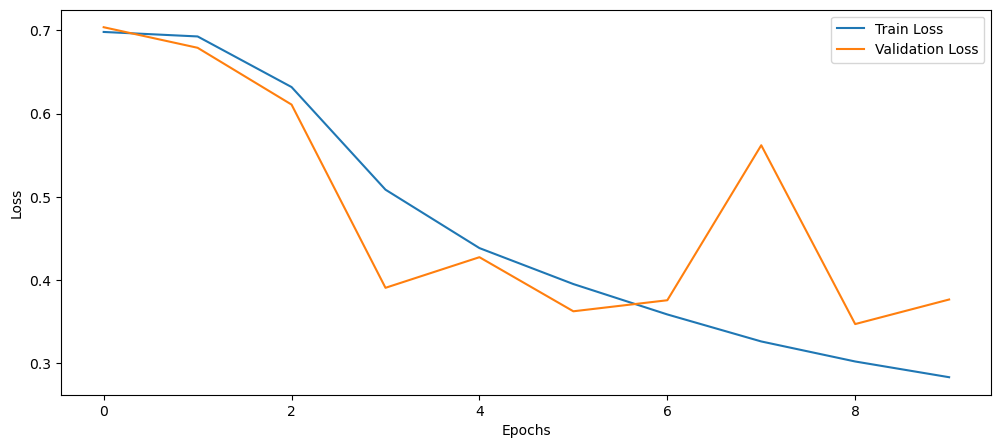

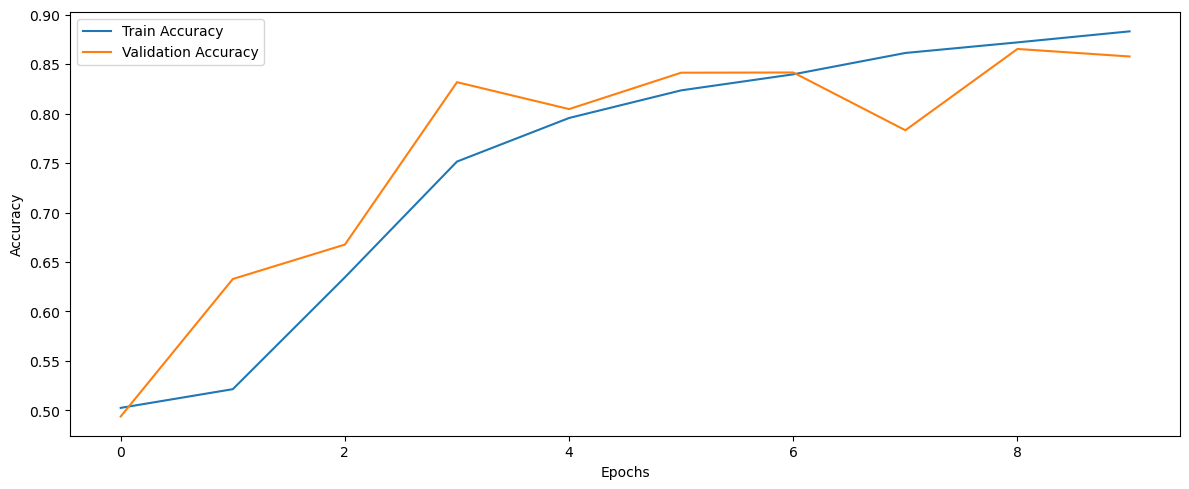

In [28]:
## Visualization

plt.figure(figsize=(12,5))

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplots(figsize=(12,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


782/782 ━━━━━━━━━━━━━━━━━━━━ 86s 109ms/step


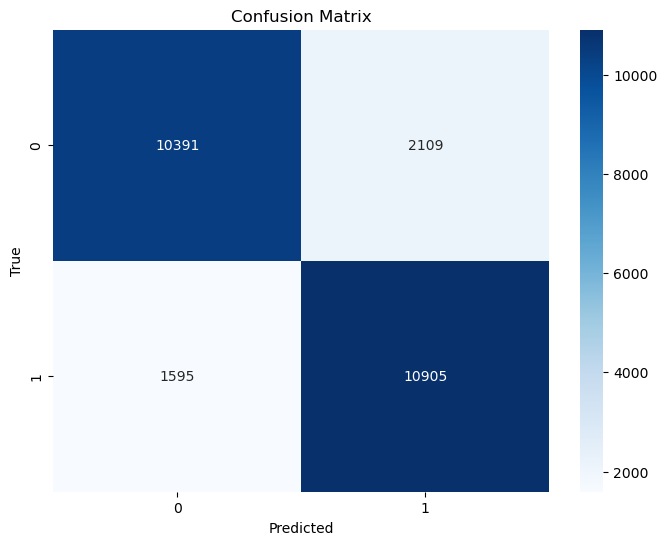

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = (imdb_model.predict(test_data) > 0.5).astype(int)
cm = confusion_matrix(test_label, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()